In [448]:
# notebook to recreate Mingkang's simulation of qubit-SNAIL coupling gates
# using my refactored version of his code

In [449]:
import numpy as np
from qutip import Options
import qutip as qt
import matplotlib.pyplot as plt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [450]:
qubit1 = QubitMode(name="q1", dim=2, freq=5.06167, alpha=-0.161, T1=1e2, T2=5e1)
qubit2 = QubitMode(name="q2", dim=2, freq=4.54944, alpha=-0.1275, T1=1e2, T2=5e1)
qubit3 = QubitMode(name="q3", dim=2, freq=4.16829, alpha=-0.160, T1=1e2, T2=5e1)
qubits = [qubit1, qubit2]  # , qubit3]
snail = SNAILMode(name="s", freq=4.27515, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    # frozenset([qubit3, snail]): 2 * np.pi * 0.04875,
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

# get dressed frequencies
qubit_freqs = [qs.dressed_freqs.get(q) for q in qubits]

In [451]:
# Step 1. construct the linear Hamiltonian
HL = 0
# for m in qs.modes:
#     HL += m.freq * qs.modes_num[m]

HL += snail.freq * qs.modes_num[snail]

# Step 2. construct the non-linear part of the Hamiltonian
# add the SNAIL non-linearity
HNl = snail.g3 / 6 * (qs.modes_field[snail]) ** 3
for q in qubits:
    # HNl += q.alpha / 12 * (qs.modes_field[q]) ** 2
    HNl -= q.freq * (qs.modes_Z[q] / 2)

# Step 3. Add the coupling terms
Hc = 0
for c, g in qs.couplings.items():
    q1, q2 = c
    Hc += g * (qs.modes_field[q1] * qs.modes_field[q2])

H0 = HL + HNl + Hc

# pump_term = qs.modes_a_dag[snail] - qs.modes_a[snail]
pump_term = qs.modes_a_dag[snail] + qs.modes_a[snail]

In [452]:
# create an initial state
# psi0 = qs.prepare_tensor_fock_state([(qubit2, 1)])
eigenvalues, eigenvectors = H0.eigenstates()
psi0 = eigenvectors[2]

In [453]:
# define desired unitary and expected final state
# assumes the iSWAP is on qubit1 and qubit2
# U = qt.tensor(
#     qt.qip.operations.iswap(N=2), qt.identity(qubit3.dim), qt.identity(snail.dim)
# )
U = qt.qip.operations.iswap(N=2)

psi0_rho = qt.ptrace(psi0, [0, 1])
expected_psi = qt.Qobj(U * psi0_rho * U.dag())

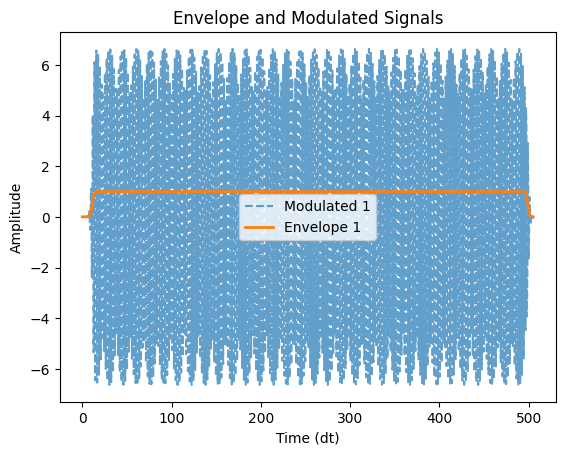

In [454]:
# Step 3. construct the pump term
# Define experiment constants
# define frequency and amplitude ranges
# drive at qubit-qubit conversion with some detuning
width_d = 500
N = 20

detuning_flist = 1000 * np.linspace(-0.005, 0.002, N)  # MHz
flist = 2 * np.pi / 1000 * (detuning_flist) + abs(qubit1.freq - qubit2.freq)
alist = np.linspace(4, 9, N)
args = {
    "shape": Pulse.smoothbox,
    "shape_params": {"t0": 5, "width": width_d},
}
t_list = np.linspace(0, 5 + width_d, 1000)

# plot an example pulse from the experiment to verify its shape
omega_p = flist[int(N / 2)]
amp_p = alist[int(N / 2)]
pulse = Pulse(omega=omega_p, amp=amp_p)

# Plot the Gaussian pulse shape
Pulse.plot_pulse([(pulse, args)], t_list)

H_pump = [pump_term, pulse.drive]

In [455]:
# # collapse operators
c_ops = []
# for mode in qs.modes:
# c_ops.append(mode.collapse_operators(qs))

In [456]:
def simulation_task(freq_amp_tuple):
    freq, amp = freq_amp_tuple
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = [pump_term, pulse.drive]
    H = [H0, H_pump]

    solve_result = qt.mesolve(H, psi0, t_list, c_ops, args=args, options=opts)
    final_state = solve_result.states[-1]

    # ground_state_populations = [
    #     qs.mode_population_expectation(final_state, mode, 0) for mode in qs.modes
    # ]
    # Calculate fidelity with the expected final state
    final_state = qt.ptrace(final_state, [0, 1])
    fidelity = qt.fidelity(expected_psi, final_state)

    # Return input parameters along with the results
    return freq, amp, None, fidelity


# Prepare the parameters for parallel execution
freq_amp_pairs = [(f, a) for f in flist for a in alist]
# Run the simulations in parallel
results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

10.0%. Run time:  42.03s. Est. time left: 00:00:06:18
20.0%. Run time:  74.51s. Est. time left: 00:00:04:58
30.0%. Run time: 113.34s. Est. time left: 00:00:04:24
40.0%. Run time: 144.41s. Est. time left: 00:00:03:36
50.0%. Run time: 175.50s. Est. time left: 00:00:02:55
60.0%. Run time: 210.95s. Est. time left: 00:00:02:20
70.0%. Run time: 242.08s. Est. time left: 00:00:01:43
80.0%. Run time: 278.64s. Est. time left: 00:00:01:09
90.0%. Run time: 315.64s. Est. time left: 00:00:00:35


In [ ]:
# Process results
# ground_state_populations = np.zeros((len(qs.modes), len(alist), len(flist)))
fidelity_matrix = np.zeros((len(alist), len(flist)))

freq_to_idx = {freq: idx for idx, freq in enumerate(flist)}
amp_to_idx = {amp: idx for idx, amp in enumerate(alist)}

# Process results with guaranteed matching of parameters and results
for result in results:
    freq, amp, populations, fidelity = result
    freq_idx = freq_to_idx[freq]
    amp_idx = amp_to_idx[amp]

    # # Store ground state populations
    # for k, pop in enumerate(populations):
    #     ground_state_populations[k, amp_idx, freq_idx] = pop

    # Store fidelity
    fidelity_matrix[amp_idx, freq_idx] = fidelity

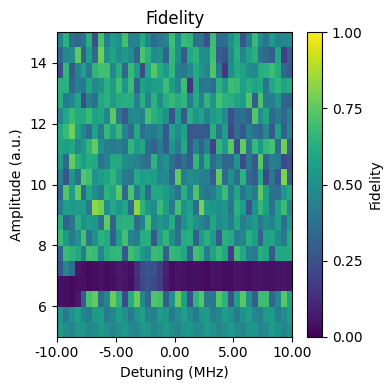

In [ ]:
# Prepare the plot
# fig, axes = plt.subplots(1, len(qs.modes), figsize=(len(qs.modes) * 4, 4))

# Conversion factor from radian frequency to GHz
rad_to_GHz = 1 / (2 * np.pi)

# Define the number of ticks for the detuning x-axis
n_xticks = 5  # Adjust the number of ticks as needed

# # Plot data for each mode
# for k, mode in enumerate(qs.modes):
#     im = axes[k].imshow(
#         # ground_state_populations[k],
#         # extent=[flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, alist[0], alist[-1]],
#         extent=[detuning_flist[0], detuning_flist[-1], alist[0], alist[-1]],
#         aspect="auto",
#         origin="lower",
#         vmin=0.0,
#         vmax=1.0,  # Set color bar scale from 0.0 to 1.0
#     )
#     axes[k].set_title(f"Mode: {mode.name}")
#     # axes[k].set_xlabel("Frequency (GHz)")
#     axes[k].set_xlabel("Detuning (MHz)")
#     axes[k].set_ylabel("Amplitude (a.u.)")

#     # Customize x-axis ticks
#     # xticks = np.linspace(flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, n_xticks)
#     xticks = np.linspace(detuning_flist[0], detuning_flist[-1], n_xticks)
#     axes[k].set_xticks(xticks)
#     axes[k].set_xticklabels([f"{x:.2f}" for x in xticks])  # Format the tick labels

#     # Add color bar
#     cbar = fig.colorbar(
#         im, ax=axes[k], orientation="vertical", label="Ground State Population"
#     )
#     cbar.set_ticks(np.linspace(0, 1, 5))  # Customize color bar ticks

# plot fidelity instead
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
im = axes.imshow(
    fidelity_matrix,
    extent=[detuning_flist[0], detuning_flist[-1], alist[0], alist[-1]],
    aspect="auto",
    origin="lower",
    vmin=0.0,
    vmax=1.0,  # Set color bar scale from 0.0 to 1.0
)
axes.set_title("Fidelity")
axes.set_xlabel("Detuning (MHz)")
axes.set_ylabel("Amplitude (a.u.)")

# Customize x-axis ticks
xticks = np.linspace(detuning_flist[0], detuning_flist[-1], n_xticks)
axes.set_xticks(xticks)
axes.set_xticklabels([f"{x:.2f}" for x in xticks])  # Format the tick labels

# Add color bar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", label="Fidelity")
cbar.set_ticks(np.linspace(0, 1, 5))  # Customize color bar ticks


plt.tight_layout()
plt.show()

In [ ]:
# Find the pulse parameters that maximize fidelity
max_fidelity = np.max(fidelity_matrix)
max_fidelity_indices = np.where(fidelity_matrix == max_fidelity)

# # Find the pulse the maximized ground state fidelity of k=1
# # ground_state_populations[k, amp_idx, freq_idx] = pop
# max_ground_state_populations = np.max(ground_state_populations[1])
# max_ground_state_populations_indices = np.where(
#     ground_state_populations[1] == max_ground_state_populations
# )
# max_pop_amp_idx, max_pop_freq_idx = (
#     max_ground_state_populations_indices[0][0],
#     max_ground_state_populations_indices[1][0],
# )

# Retrieve the amplitude and width that correspond to the maximum fidelity
# max_pop_freq = flist[max_pop_freq_idx]
# max_pop_amp = alist[max_pop_amp_idx]

# Since the indices are returned in a tuple of arrays, we take the first element
max_fidelity_amp_idx, max_fidelity_freq_idx = (
    max_fidelity_indices[0][0],
    max_fidelity_indices[1][0],
)

# Retrieve the amplitude and width that correspond to the maximum fidelity
max_fidelity_freq = flist[max_fidelity_freq_idx]
max_fidelity_amp = alist[max_fidelity_amp_idx]

print(f"Max fidelity: {max_fidelity:.4f}")
print(f"Pulse freq for max fidelity: {max_fidelity_freq:.2f} GHz")
print(f"Pulse amplitude for max fidelity: {max_fidelity_amp:.2f} a.u.")

# print(f"Max ground state population: {max_ground_state_populations:.4f}")
# print(f"Pulse freq for max ground state population: {max_pop_freq:.2f} GHz")
# print(f"Pulse amplitude for max ground state population: {max_pop_amp:.2f} a.u.")

Max fidelity: 0.8309
Pulse freq for max fidelity: 3.20 GHz
Pulse amplitude for max fidelity: 9.21 a.u.


In [ ]:
# we want to construct the observables for H0, so that the expectation values
# are the dressed states
# e_ops = [
#     qt.Qobj(eigenstate) * qt.Qobj(eigenstate).dag() for eigenstate in H0.eigenstates()
# ]

e_ops = [qs.modes_num[m] for m in qs.modes]

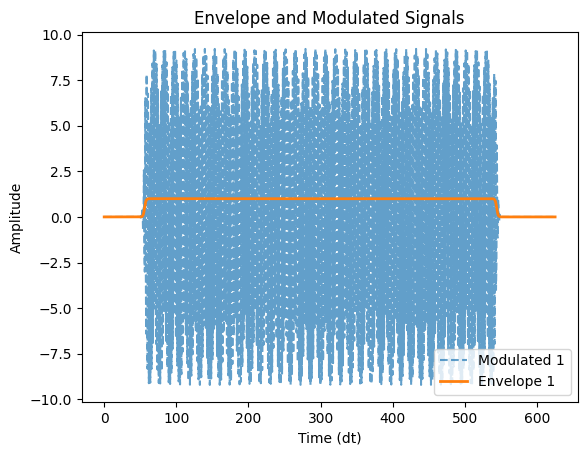

In [ ]:
# pulse = Pulse(omega=max_fidelity_freq, amp=max_fidelity_amp)
pulse = Pulse(omega=max_fidelity_freq, amp=max_fidelity_amp)
Pulse.plot_pulse([(pulse, args)], t_list)

In [ ]:
H_pump = [pump_term, pulse.drive]
H = [H0, H_pump]
solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts, e_ops=e_ops)

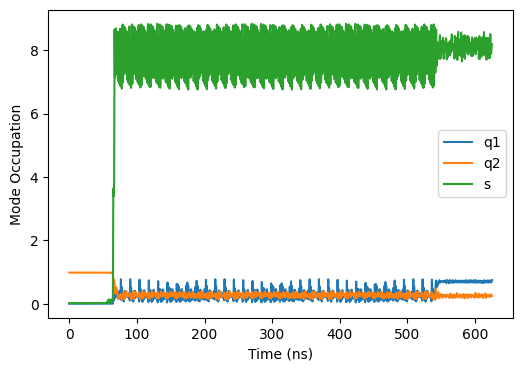

In [ ]:
# Plot the state evolution (<n> vs time) for each mode (one plot total)
fig, ax = plt.subplots(figsize=(6, 4))
for k, mode in enumerate(qs.modes):
    # if k == 2:  # don't plot the SNAIL
    #     continue
    ax.plot(t_list, solve_result.expect[k], label=mode.name)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Mode Occupation")
ax.legend()
plt.show()